In [1]:
from pandas_datareader import data as pdr
import FinanceDataReader as fdr
import yfinance as yf
from pykrx import stock
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 함수

In [2]:
def myplot(df, nrows=5,  kind='line', title='제목', labels=False):  
#     if nrows > 0:
#         print(df.head(nrows))
#     else:
#         print(df.tail(nrows))
    if labels:
        cols = df.columns
        for i, col in enumerate(cols):
            df[col].plot(label=labels[i], kind=kind)
    else :
        df.plot(kind=kind)
    
    plt.title(title)
    plt.legend()
    plt.show()


In [3]:
def myplotmix(df1, df2, y1='ylabel-1', y2='ylabel-2', kind1='bar', kind2='line', title='제목',  nrows1=5, nrows2=5,  labels=False):  
    ytl=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if nrows1 > 0:
        print(df1.head(nrows1))
    elif nrows1 < 0:
        print(df1.tail(nrows1))
    if nrows2 > 0:
        print(df2.head(nrows2))
    else:
        print(df2.tail(nrows2))
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2=ax1.twinx()
    if kind1 == 'line':
        df1.plot(kind=kind1, ax=ax2, marker='d',color='#e35f62')  #color='y', 
        df2.plot(kind=kind2, ax=ax1)  #bar
    else:
        df1.plot(kind=kind1, ax=ax1,color='#bcbd22')
        df2.plot(kind=kind2, ax=ax2) #color='y',
        
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d') 
    # ax1.set_xticklabels(df['date'])    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel(y1) #, color='red')
    ax2.set_ylabel(y2) #, color='red')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(title)
    ax1.grid(False)
    
    plt.show()

- 데이터 불러오기

In [4]:
df = pd.read_excel('WTI선물.xlsx', sheet_name='M')
edf = pd.read_excel('WTI선물.xlsx', sheet_name='EXP')

In [5]:
df.set_index('Date',inplace=True)
df.head()

,Spot,Front,Second
Date,,,
2017-12-28,59.84,59.84,59.87
2017-12-27,59.64,59.64,59.69
2017-12-26,59.97,59.97,60.00
2017-12-22,58.42,58.47,58.54
2017-12-21,58.33,58.36,58.40


In [6]:
edf.head()

,Ticker,Month,Last Trade,Last Price
0,CLG00,2000-02-01,01/20/00,29.66
1,CLH00,2000-03-01,02/22/00,29.62
2,CLJ00,2000-04-01,03/21/00,28.00
3,CLK00,2000-05-01,04/19/00,27.35
4,CLM00,2000-06-01,05/22/00,28.61


In [7]:
edf.set_index('Month',inplace=True)

In [8]:
print(edf.index.max(), edf.index.min())

2017-12-26 00:00:00 2000-02-01 00:00:00


In [9]:
print(df.index.max(), df.index.min())

2017-12-28 00:00:00 2010-01-04 00:00:00


In [10]:
# 만기일 알람
gdf = pd.concat([df,edf], axis=1, join='outer')
df['exp']= np.nan
cnt = 0
for d in df.index:
    if d in edf.index:
        df.loc[d,'exp'] = 1
        cnt += 1
df.fillna(0,inplace=True)

In [11]:
df.head()

,Spot,Front,Second,exp
Date,,,,
2017-12-28,59.84,59.84,59.87,0.0
2017-12-27,59.64,59.64,59.69,0.0
2017-12-26,59.97,59.97,60.00,1.0
2017-12-22,58.42,58.47,58.54,1.0
2017-12-21,58.33,58.36,58.40,1.0


In [12]:
df.head()
print(cnt)

191


# 현물가

In [13]:
print(df.index.max(), df.index.min())

2017-12-28 00:00:00 2010-01-04 00:00:00


In [14]:
# 2010년 날짜를 2017년 지금까지 들고있다면?
df.loc[df.index.max(),'Spot'] - df.loc[df.index.min(),'Spot'] 

-21.67

## 선물가
- 만기일(exp=1)에는 롤오버 발생
- 롤오버: 차월만기금(second) - 당월만기금(front)    # 다음달꺼가 더 비쌈(이자붙음)   

<AxesSubplot:xlabel='Date'>

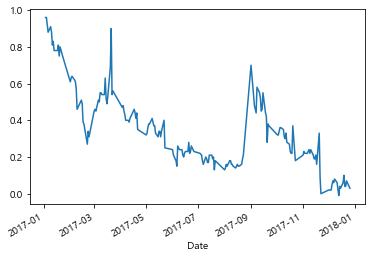

In [22]:
temp= df[df['exp']==1][['Second','Front']]
temp['diff'] = temp['Second'] - temp['Front']
temp.head()
temp['diff'].plot()

In [19]:
rollover = df.loc[df['exp']==1,'Second'] - df.loc[df['exp']==1,'Front'] # 롤오버 갈아탔을 때 비용

rov_tot = np.array(rollover).sum()

In [21]:
# 2010년 날짜를 2017년 지금까지 들고있다면? (rollover : 이자까지 감안)
df.loc[df.index.max(),'Spot'] - ( df.loc[df.index.min(),'Spot'] + rov_tot )

-87.81000000000003

# 이론가 산출
이론가 = 지수가격 * EXP( (cd금리) * t)

In [6]:
def 이론가(선물지수, 이자율, 배당률, 오늘, 만기일):
    선물이론가 = 선물지수 * np.exp((이자율-배당률) * np.busday_count(오늘, 만기일)/252)
    return 선물이론가

In [7]:
# sample data
temp = pd.DataFrame({
                    'date':pd.date_range('2021-01-04',periods=4),
                   '지수': [100,101,102,103]   
                   'b':[1,1,1,1]
                })

temp['date']  = pd.to_datetime(temp['date'] , format='%Y-%m-%d', errors='raise')
temp = temp.set_index('date')

In [8]:
이자율 = 0.0225
배당률 = 0.015

for date in temp.index:
    오늘 = date.date()
    만기일 = pd.to_datetime('2021-01-08').date()
    선물지수 = temp.loc[date,'지수']
    선물이론가 = 이론가(선물지수,이자율,배당률,오늘, 만기일)
    temp.loc[date,'선물이론가']= 선물이론가
temp

,지수,선물이론가
date,,
2021-01-04,100,100.011905
2021-01-05,101,101.009018
2021-01-06,102,102.006072
2021-01-07,103,103.003066
